# Anoxic Event Group
OOI Data Labs Workshop - March 2019

**Working Title**: The impact of interaction between the mid-depth ocean and coastal waters on fisheries

**Short Description**: Explore the relationship between atmospheric processes (wind), oceanic processes (currents and upwelling) and how these processes affect benthic organisms and our ability to fish for them.

**Your Objective** (Challenge Question): How do changing weather conditions and ocean circulation patterns affect our ability to fish for benthic organisms like crabs?



In [60]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt

# Setup default plot styles
import seaborn as sns
sns.set()

## Request Data from OOINet

* **Wind data**: Oregon Shelf Surface Mooring, Surface Buoy, Bulk Meteorological Instrument Package (CE02SHSM-SBD11-06-METBKA000) recovered_host
* **Dissolved oxygen**: Oregon Inshore Surface Mooring, Seafloor Multi-function Mode (MFN), Dissolved Oxygen (CE01ISSM-MFD37-03-DOSTAD000) recovered_inst
* **Temperature**: Oregon Inshore Surface Mooring, Seafloor Multi-function Mode (MFN), (CE01ISSM-MFD37-03-CTDBPC000) recovered_inst
* Dissolved oxygen profile from shelf edge/slope station, if possible

In [0]:
def request_data(reference_designator,method,stream,start_date,end_date):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'beginDT':start_date,
    'endDT':end_date,
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# # Met Data
# request_data('CE02SHSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')

# # DO Data
# request_data('CE01ISSM-MFD37-03-DOSTAD000','recovered_inst','dosta_abcdjm_ctdbp_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')

# # Temperature Data
# request_data('CE01ISSM-MFD37-03-CTDBPC000','recovered_inst','ctdbp_cdef_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')

# # pH 7m Data
# request_data('CE01ISSM-RID16-06-PHSEND000','recovered_inst','phsen_abcdef_instrument',
#              '2017-01-01T00:00:00.000Z','2018-01-01T00:00:00.000Z')

# # pH 25m
# request_data('CE01ISSM-MFD35-06-PHSEND000','recovered_inst','phsen_abcdef_instrument',
#              '2017-01-01T00:00:00.000Z','2018-01-01T00:00:00.000Z')

# # Glider Data
# request_data('CE05MOAS-GL382-04-DOSTAM000','recovered_host','dosta_abcdjm_glider_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')
# request_data('CE05MOAS-GL384-04-DOSTAM000','recovered_host','dosta_abcdjm_glider_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')
# request_data('CE05MOAS-GL384-04-DOSTAM000','recovered_host','dosta_abcdjm_glider_recovered',
#              '2017-04-20T00:00:00.000Z','2017-07-20T00:00:00.000Z')

# # Profiler Data
# request_data('CE04OSPS-SF01B-2A-CTDPFA107','streamed','ctdpf_sbe43_sample',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')


## Loading Data Files

In [0]:
# Resultant Dataset Directories
url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190327T192845-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190327T193104-CE01ISSM-MFD37-03-DOSTAD000-recovered_inst-dosta_abcdjm_ctdbp_instrument_recovered/catalog.html'
url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190327T193404-CE01ISSM-MFD37-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'

# url_ph7 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190423T175749-CE01ISSM-RID16-06-PHSEND000-recovered_inst-phsen_abcdef_instrument/catalog.html'
url_ph7 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190423T185447-CE01ISSM-RID16-06-PHSEND000-recovered_inst-phsen_abcdef_instrument/catalog.html'
# url_ph25 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190423T175808-CE01ISSM-MFD35-06-PHSEND000-recovered_inst-phsen_abcdef_instrument/catalog.html'
url_ph25 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190423T185512-CE01ISSM-MFD35-06-PHSEND000-recovered_inst-phsen_abcdef_instrument/catalog.html'

url_gl382 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190423T175857-CE05MOAS-GL382-04-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/catalog.html'
url_gl384 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190423T175911-CE05MOAS-GL384-04-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/catalog.html'
url_gl384_full = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190517T201634-CE05MOAS-GL384-04-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/catalog.html'

url_profiler = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190423T180119-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/catalog.html'


In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  # ds = ds.chunk({'time': 100}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

## Oregon Mooring Dataset

In [0]:
# Load the datasets
data_met = get_data(url_met,'velpt')
data_do = get_data(url_do,'CTDBPC000')
data_ctd = get_data(url_ctd)

In [0]:
# Convert DO from micromole/kg to mg/L
# Reference https://ocean.ices.dk/Tools/UnitConversion.aspx
# See also https://wiki.pangaea.de/wiki/Conversion

data_do['do'] = data_do.dissolved_oxygen * 1.025 / (44.661*0.7)
data_do['do'].attrs['long_name'] = 'DO'
data_do['do'].attrs['units'] = 'mg/L'

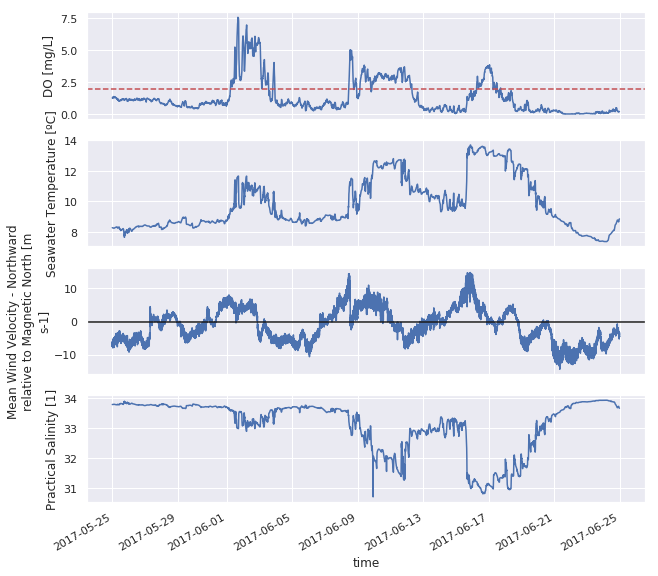

In [67]:
# Plot the data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
# data_do.dissolved_oxygen.plot(ax=ax1) # Original DO
data_do.do.plot(ax=ax1) # Converted DO
data_ctd.ctdbp_seawater_temperature.plot(ax=ax2)
data_met.northward_wind_velocity.plot(ax=ax3)
data_ctd.practical_salinity.plot(ax=ax4);

# Add line at 2mg/L for DO
xlim = ax1.get_xlim()
ax1.plot([xlim[0],xlim[1]],[2,2],'r--')

# Add 0 line for Wind
ax3.plot([xlim[0],xlim[1]],[0,0],'k')
ax3.set_xlim(xlim);

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

plt.savefig("anoxia_june2017.png");

In [0]:
# Other variables?
# data_met.air_temperature.plot()
# data_met.barometric_pressure.plot()
# data_met.longwave_irradiance.plot()
# data_ctd.practical_salinity.plot()
# data_ctd.pressure.plot()

## Merge and export

In [0]:
# Resample/average to 15 minutes
avgint = '1h' #'15min'
# a = data_do['dissolved_oxygen'].load().resample(time=avgint).mean()
a = data_do['do'].load().resample(time=avgint).mean()
b = data_ctd['ctdbp_seawater_temperature'].load().resample(time=avgint).mean()
c = data_met['northward_wind_velocity'].load().resample(time=avgint).mean()
d = data_ctd['practical_salinity'].load().resample(time=avgint).mean()

In [70]:
# Merge the datasets
x = xr.merge([a,b,c,d]).to_dataframe()

# Print the first few rows
x.head()

,do,ctdbp_seawater_temperature,northward_wind_velocity,practical_salinity
time,,,,
2017-05-25 00:00:00,1.288707,8.264365,-6.759833,33.786660
2017-05-25 01:00:00,1.322993,8.246202,-6.364333,33.791832
2017-05-25 02:00:00,1.345121,8.238258,-6.194167,33.793758
2017-05-25 03:00:00,1.321968,8.260391,-5.834000,33.789965
2017-05-25 04:00:00,1.326248,8.286342,-5.266667,33.784464


In [0]:
# Export to CSV
x.to_csv('anoxia2017.csv')

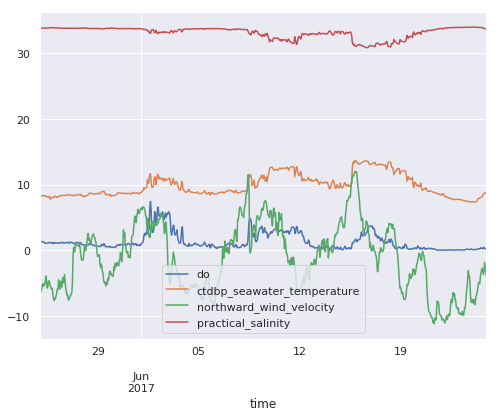

In [72]:
# Quicklook plot
x.plot(figsize=(8,6));

## Glider 384 Dataset

Todos from Call #2
* Convert Glider DO to match conversion used for mooring
* Pull out one profile from the continental slope with the DO units the same (mg/L) as timeseries plot, as well as corresponding temp and salinity profiles
* Take one slice and plot x as distance offshore, but also include timestamps

Todos from Call #3
* Show distance offshore on x-axis
* Ylabels should be depth. Title or colorbar can show variable name
* Show just one nearshore profile in 3rd plot

In [73]:
!pip install cmocean
import cmocean
import pandas as pd

In [0]:
# Map stuff
!apt-get -qq install python-cartopy python3-cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [0]:
# Load data
data_gl384 = get_data(url_gl384_full,'CTDGV').to_dataframe()

In [0]:
# Convert DO from micromole/L to mg/L (this is different that above)
# Reference https://wiki.pangaea.de/wiki/Conversion
data_gl384['do'] = data_gl384.sci_oxy4_oxygen / (44.661*0.7)

In [0]:
# Remove glider surfacing points
data_gl384 = data_gl384[data_gl384.int_ctd_pressure > 1]

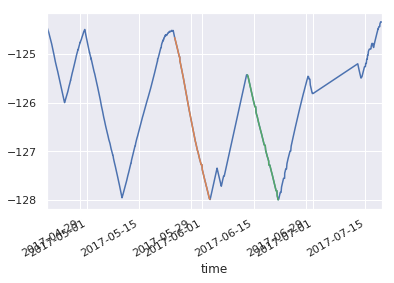

In [78]:
# Focus on single transect - Quickplot to select limits
data_gl384.lon.plot()
data_gl384['2017-05-24 15:00':'2017-06-03 04:00'].lon.plot(); 
data_gl384['2017-06-13 06:00':'2017-06-21 14:00'].lon.plot();
plt.savefig("glider_transects.png")

In [0]:
# Transect 1

# Bad Data - The transect started at 2Z, but switched to 15Z to remove some bad salinity profiles
# data_gl384a = data_gl384['2017-05-24 02:00':'2017-05-25 04:00']

# Good Data
data_gl384a = data_gl384['2017-05-24 15:00':'2017-06-03 04:00'][0::30] #Downsample as well

# Trransect 2
# data_gl384b = data_gl384['2017-06-13 06:00':'2017-06-21 14:00']

In [0]:
# Calculate distance from CE01ISSM
import geopy.distance
data_gl384a['distance'] = data_gl384a.apply(lambda row: geopy.distance.distance((44.66,-124.095),(row['lat'],row['lon'])).km, axis=1)

### Transect #1

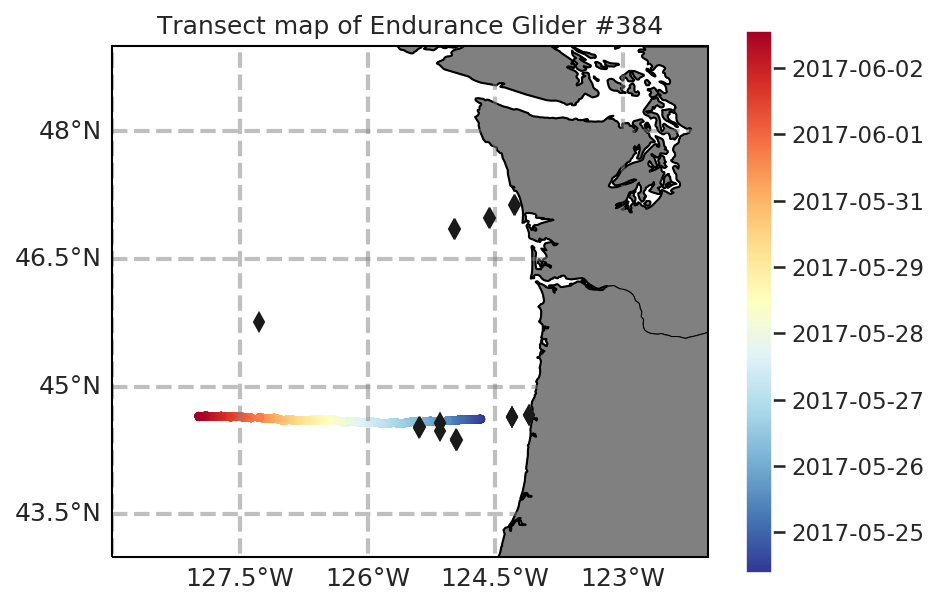

In [81]:
# Glider Deployment Map
fig = plt.figure(figsize=(6.4,4.8),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-129,-122,43,49], crs=ccrs.PlateCarree())

# Basemaps
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black",facecolor='grey')
ax.coastlines('10m', linewidth=1)

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.MaxNLocator(6)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Glider Data
plt.scatter(data_gl384a.lon,data_gl384a.lat,c=data_gl384a.index,marker='.',cmap='RdYlBu_r',transform=ccrs.Geodetic());
cbar = plt.colorbar()
# Fix the colorbar ticks
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

# Add the OOI Sites
sites = pd.read_csv('https://github.com/seagrinch/data-team-python/raw/master/infrastructure/sites.csv')
plt.plot(sites.longitude,sites.latitude,'kd',markersize=6)

plt.title('Transect map of Endurance Glider #384');

plt.savefig("glider384a_map.png")

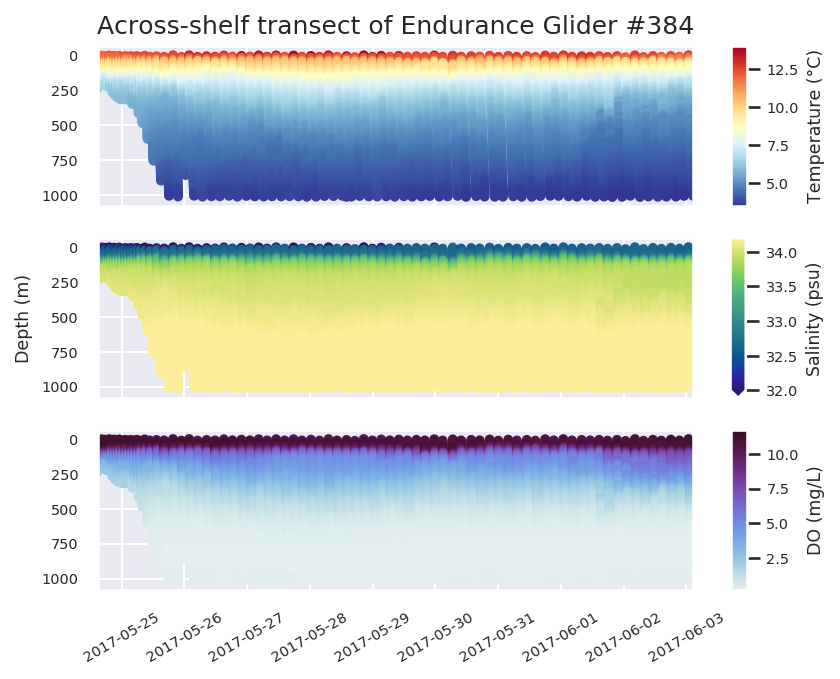

In [82]:
# Plot the data - Time on x-axis
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(6.4,4.8)
# fig.set_size_inches(8,8)
fig.set_dpi(150)

ms = 56 #marker size
a1 = ax1.scatter(data_gl384a.index, data_gl384a.int_ctd_pressure, c=data_gl384a.sci_water_temp, marker=".", s=ms, cmap='RdYlBu_r')
a2 = ax2.scatter(data_gl384a.index, data_gl384a.int_ctd_pressure, c=data_gl384a.practical_salinity, marker=".", s=ms, cmap=cmocean.cm.haline, vmin=32, vmax=34.2)
a3 = ax3.scatter(data_gl384a.index, data_gl384a.int_ctd_pressure, c=data_gl384a.do, marker=".", s=ms, cmap=cmocean.cm.dense) #vmin=0, vmax=300

cb1 = plt.colorbar(a1,ax=ax1, aspect=10)
cb2 = plt.colorbar(a2,ax=ax2,extend='min', aspect=10)
cb3 = plt.colorbar(a3,ax=ax3, aspect=10)
cb1.set_label('Temperature (°C)',fontsize='x-small')
cb2.set_label('Salinity (psu)',fontsize='x-small')
cb3.set_label('DO (mg/L)',fontsize='x-small')

ax2.set_ylabel("Depth (m)",fontsize='x-small')

ax1.invert_yaxis()
ax1.set_xlim(min(data_gl384a.index),max(data_gl384a.index));
ax3.xaxis.set_tick_params(rotation=30);
ax1.set_title('Across-shelf transect of Endurance Glider #384')

ax1.tick_params(labelsize='xx-small')
ax2.tick_params(labelsize='xx-small')
ax3.tick_params(labelsize='xx-small')
cb1.ax.tick_params(labelsize='xx-small')
cb2.ax.tick_params(labelsize='xx-small')
cb3.ax.tick_params(labelsize='xx-small')

plt.savefig("glider384a_transect_time.png")

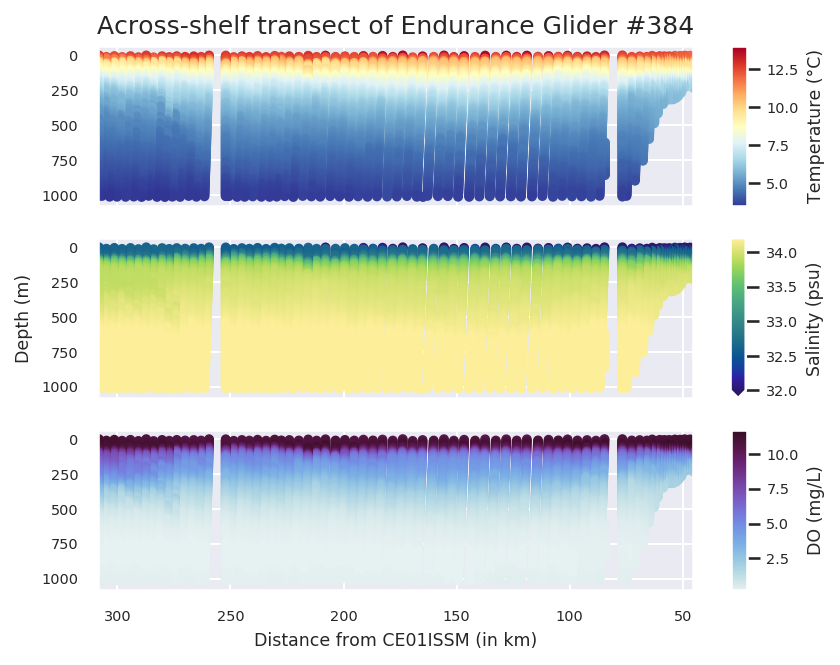

In [83]:
# Plot the data - Distance on x-axis
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(6.4,4.8)
# fig.set_size_inches(8,8)
fig.set_dpi(150)

ms = 56 #marker size
a1 = ax1.scatter(data_gl384a.distance, data_gl384a.int_ctd_pressure, c=data_gl384a.sci_water_temp, marker=".", s=ms, cmap='RdYlBu_r')
a2 = ax2.scatter(data_gl384a.distance, data_gl384a.int_ctd_pressure, c=data_gl384a.practical_salinity, marker=".", s=ms, cmap=cmocean.cm.haline, vmin=32, vmax=34.2)
a3 = ax3.scatter(data_gl384a.distance, data_gl384a.int_ctd_pressure, c=data_gl384a.do, marker=".", s=ms, cmap=cmocean.cm.dense) #vmin=0, vmax=300

cb1 = plt.colorbar(a1,ax=ax1, aspect=10)
cb2 = plt.colorbar(a2,ax=ax2,extend='min', aspect=10)
cb3 = plt.colorbar(a3,ax=ax3, aspect=10)
cb1.set_label('Temperature (°C)',fontsize='x-small')
cb2.set_label('Salinity (psu)',fontsize='x-small')
cb3.set_label('DO (mg/L)',fontsize='x-small')

ax2.set_ylabel("Depth (m)",fontsize='x-small')
ax1.invert_yaxis()

ax3.set_xlabel('Distance from CE01ISSM (in km)',fontsize='x-small')
ax1.set_xlim(min(data_gl384a.distance),max(data_gl384a.distance));
ax1.invert_xaxis()

ax1.set_title('Across-shelf transect of Endurance Glider #384')

ax1.tick_params(labelsize='xx-small')
ax2.tick_params(labelsize='xx-small')
ax3.tick_params(labelsize='xx-small')
cb1.ax.tick_params(labelsize='xx-small')
cb2.ax.tick_params(labelsize='xx-small')
cb3.ax.tick_params(labelsize='xx-small')

plt.savefig("glider384a_transect_distance.png")

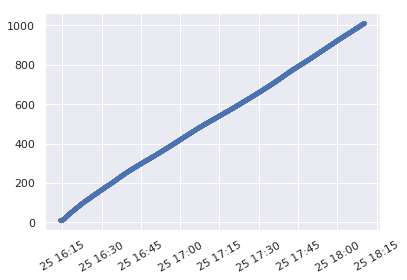

In [84]:
# Extract one profile
data_gl384a1 = data_gl384['2017-05-25 16:00':'2017-05-25 19:00']
plt.plot(data_gl384a1.index,data_gl384a1.int_ctd_pressure,'.')
plt.xticks(rotation=30);

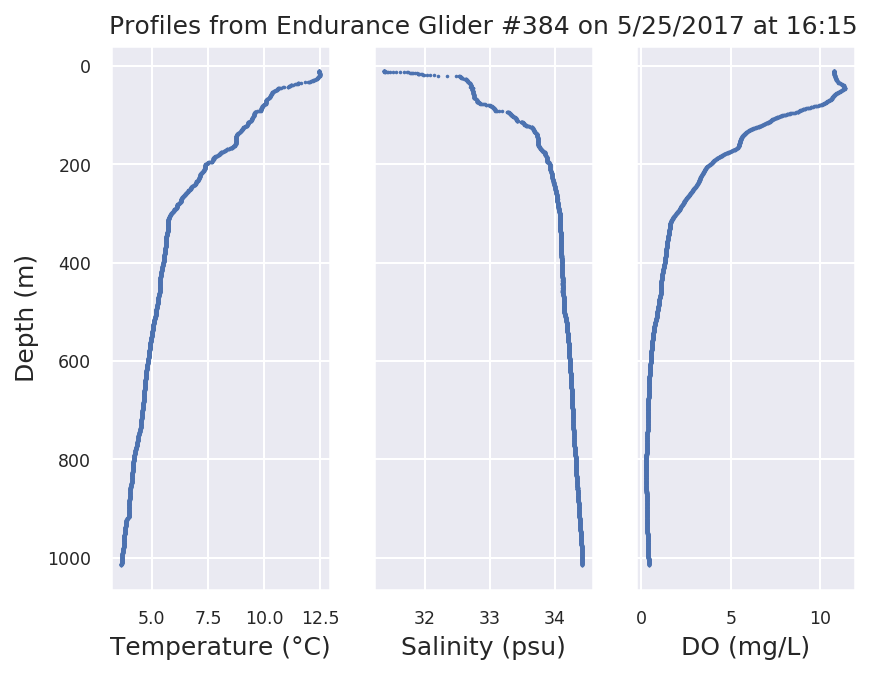

In [85]:
# Plot the data
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex=False, sharey=True)
fig.set_size_inches(6.4,4.8)
fig.set_dpi(150)

a1 = ax1.scatter(data_gl384a1.sci_water_temp, data_gl384a1.int_ctd_pressure, marker=".", s=2)
a2 = ax2.scatter(data_gl384a1.practical_salinity, data_gl384a1.int_ctd_pressure, marker=".", s=2)
a3 = ax3.scatter(data_gl384a1.do, data_gl384a1.int_ctd_pressure, marker=".", s=2)

ax1.set_ylabel("Depth (m)")
ax1.set_xlabel("Temperature (°C)")
ax2.set_xlabel("Salinity (psu)")
ax3.set_xlabel("DO (mg/L)")

ax1.invert_yaxis()
ax2.set_title('Profiles from Endurance Glider #384 on 5/25/2017 at 16:15')

ax1.tick_params(labelsize='x-small')
ax2.tick_params(labelsize='x-small')
ax3.tick_params(labelsize='x-small')

plt.savefig("glider384a_profiles.png")